## Project 2. Part 2 (Explore, Clean & Model)

In [40]:
import re
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from diagnostic_plots import diagnostic_plots

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
%matplotlib inline

### Define some useful functions

In [41]:
#To clean the engine_size column (convert into floats)
def clean_engine(series):
    """Takes a series of strings and converts them into floats where possible.
    Returns a list of floats."""
    values = car_ad_dataset['Engine_Size']
    new_values = []
    for value in values:
        try:
            val = float(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the price column
def clean_price(series):
    """Takes a series of strings, cleans them from text and converts them into floats where possible.
    Returns a list of floats."""
    values = series.str.split('€').str[0]
    new_values = []
    for value in values:
        try:
            val = float(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the mileage column
def clean_kms(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('km').str[0]
    new_values = []
    for value in values:
        try:
            val = int(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the Number of Doors column
def clean_door_count(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('/').str[0]
    new_values = []
    for value in values:
        try:
            val = int(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Convert 'Fuel type' to numeric value (Petrol = 0, Diesel = 1) !If the car is electric, it assigns NaN
def fuel_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Petrol and 1 for Diesel.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Petrol' or value == 'Petrol / LPG':
            val = int(0)
            new_values.append(val)
        elif value == 'Diesel' or value == 'Diesel / gas':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def gearbox_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Manual and 1 for Automatic.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Manual':
            val = int(0)
            new_values.append(val)
        elif value == 'Automatic':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def white_colour(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-White and 1 for White.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'White':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def red_colour(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-Red and 1 for Red.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Red / crimson':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def group_body_types(series):
    """Takes a series of body types and groups them to categories.
    Returns a list of tuples."""
    body_type_dict = {'Other': ('Other', 'Limousine'), 'Limousine':('Other', 'Limousine'), 'Coupe':('Coupe'), 'Hatchback':('Hatchback'), 'Saloon / sedan':('Saloon / sedan', 'Convertible'), 'Convertible':('Saloon / sedan', 'Convertible'), 'Wagon':('Wagon'), 'SUV / off-road':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'MPV / minivan':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Commercial':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Pick-up':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up')}
    values = series
    new_values = []
    for value in values:
        val = body_type_dict[value]
        new_values.append(val)
    return new_values
    
def numeric_body_type(series):
    """Takes a series of body types and converts them into numbers from smallest to largest.
    Returns a list of integers"""
    body_types = {('Other', 'Limousine'):np.NaN, ('Coupe'):2, ('Hatchback'):3, ('Saloon / sedan', 'Convertible'):4, ('Wagon'):5, ('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'):6}
    values = series
    new_values = []
    for value in values:
        try:
            val = body_types[value]
            new_values.append(val)
        except:
            val = np.NaN
            new_values.append(val)
    return new_values

def get_german_make(series):
    """Takes a series of car makers names and dummifies it into counties it's made at. 
     Returns a list of 1s and 0s."""
    germany = ['BMW', 'Audi', 'Open', 'Mercedes-Benz', 'Porsche', 'Volkswagen', 'Ford']
    values = series
    new_values = []
    for value in values:
        if value in germany:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values
            
def get_japanese_make(series):
    """Takes a series of car makers names and dummifies it into counties it's made at. 
     Returns a list of 1s and 0s."""
    japan = ['Toyota', 'Mazda', 'Honda', 'Nissan', 'Mitsubishi', 'Suzuki', 'Lexus']
    values = series
    new_values = []
    for value in values:
        if value in japan:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values

def get_french_make(series):
    """Takes a series of car makers names and dummifies it into counties it's made at. 
     Returns a list of 1s and 0s."""
    france = ['Renault', 'Citroen', 'Peugeot']
    values = series
    new_values = []
    for value in values:
        if value in france:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values

### Unpickle the file

In [42]:
with open('car_ad_dataset.pkl', 'rb') as picklefile:
    car_ad_dataset = pickle.load(picklefile)
    
#Verify that the result is as desired
car_ad_dataset.head()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
0,"CD player,AUX input,Navigation/GPS,Handsfree kit",Wagon,Climate control,Black,NaN,No damages,2018-02,All wheel (4х4),"Electric mirrors,Electric boot lid,Galinio vai...","1995 cm³, 190 HP (139kW)",...,"Not exploited in Lithuania,Available for leasi...",44 900 €,"ABS,Traction control system,ESP iElectronic st...","Central locking,Immobilizer,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
1,NaN,Coupe,None,Blue,NaN,No damages,1992,Rear wheel drive (RWD),Electric windows,"1998 cm³, 156 HP (115kW)",...,NaN,4 400 €\n \n Sužinokite įmoką\n ...,NaN,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R17
2,"CD player,MP3 player,Original audio system,USB...",Hatchback,NaN,NaN,NaN,No damages,2010-03,NaN,Electric windows,"1400 cm³, 89 HP (66kW)",...,Service book,5 500 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...","Central locking,Alarm",Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
3,"CD player,AUX input,Navigation/GPS,USB input,H...",SUV / off-road,NaN,NaN,NaN,No damages,2013-03,NaN,"Electric mirrors,Galinio vaizdo kamera,In-car ...","2200 cm³, 175 HP (129kW)",...,"Not exploited in Lithuania,Available for leasi...",12 700 €\n \n Sužinokite įmoką\n ...,"ABS,EBD iElectronic brakeforce distribution$(""...",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
4,Navigation/GPS,SUV / off-road,NaN,NaN,NaN,Crashed,2009-03,NaN,"Electric windows,Cruise control",4800 cm³,...,Not exploited in Lithuania,4 999 €\n \n Sužinokite įmoką\n ...,Airbags,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN


In [43]:
#Check out the shape and get info
print('The shape is:', str(car_ad_dataset.shape), '\n');
car_ad_dataset.info()

The shape is: (3020, 35) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 35 columns):
Audio/video equipment         995 non-null object
Body type                     1498 non-null object
Climate control               894 non-null object
Color                         1205 non-null object
Combined                      618 non-null object
Damage                        1498 non-null object
Date of manufacture           1498 non-null object
Driven wheels                 1098 non-null object
Electronics                   1243 non-null object
Engine                        1475 non-null object
Engine_Size                   1498 non-null object
Euro standard                 475 non-null object
Export price                  376 non-null object
Exterior                      1218 non-null object
Extra-urban                   617 non-null object
First registration country    703 non-null object
Fuel type                     1498 non-null object
Gearbo

In [44]:
car_ad_dataset.describe()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Other features,Price in Lithuania,Safety,Security,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
count,995,1498,894,1205,618,1498,1498,1098,1243,1475,...,909,1498,1146,907,1498,66,607,1493,196,782
unique,363,11,3,11,90,6,328,3,443,694,...,60,479,83,13,2,13,114,2,195,10
top,"CD player,Original audio system",Saloon / sedan,Climate control,Gray / silver,6.00,No damages,2005,Front wheel drive (FWD),"Electric windows,Cruise control","1968 cm³, 140 HP (103kW)",...,"Not exploited in Lithuania,Service book,Cataly...",650 €\n \n Sužinokite įmoką\n ...,Airbags,"Central locking,Immobilizer,Alarm",Left hand drive (LHD),Increased engine power,7.00,\n \n Check vehicle history\...,WBAUG31040PU49618,R16
freq,113,370,652,416,42,1394,25,696,156,35,...,123,51,293,249,1479,22,32,1297,2,218


In [45]:
#Explore the dataset
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       1498
Price in Lithuania            1498
Fuel type                     1498
Make_Model                    1498
Number of doors               1498
Date of manufacture           1498
Engine_Size                   1498
Damage                        1498
Steering wheel                1498
Body type                     1498
VIN check                     1493
Engine                        1475
Interior                      1258
Electronics                   1243
Exterior                      1218
Color                         1205
Mileage                       1157
Safety                        1146
Driven wheels                 1098
Number of seats               1036
Audio/video equipment          995
Other features                 909
Security                       907
Climate control                894
Wheel size                     782
MOT test expiry                773
First registration country     703
Combined                       618
Extra-urban         

### Clean the dataset

**Initial cleaning and formatting**

In [46]:
#Clean up the price column and convert to a float
car_ad_dataset['Price'] = clean_price(car_ad_dataset['Price in Lithuania'])

In [47]:
#Split the Make_Model column
car_ad_dataset['Make'], car_ad_dataset['Model'] = car_ad_dataset['Make_Model'].str.split(' ', 1).str

In [48]:
#Group Makes into countries
car_ad_dataset['Is_German'] = get_german_make(car_ad_dataset['Make'])

car_ad_dataset['Is_French'] = get_french_make(car_ad_dataset['Make'])

car_ad_dataset['Is_Japanese'] = get_japanese_make(car_ad_dataset['Make'])

In [49]:
#Clean up the Engine_Size column from l.
car_ad_dataset['Engine_Size'] = car_ad_dataset['Engine_Size'].str.split(' ', 2).str[1]
car_ad_dataset['Engine_Size_l'] = clean_engine(car_ad_dataset['Engine_Size'])

In [50]:
#Clean the Engine column
#Some of the cars don't have the cm3, so instead this takes HP or kW, will have to drop those later on!!!
car_ad_dataset['Engine_cm3'] = pd.to_numeric(car_ad_dataset['Engine'].str.split(' ').str[0])

In [51]:
#Only keep the Year of manufacture
car_ad_dataset['Year_of_manufacture'] = pd.to_numeric(car_ad_dataset['Date of manufacture'].str[:4])

In [52]:
#Clean up the milage column to remove 'km'
car_ad_dataset['Mileage_km'] = clean_kms(car_ad_dataset['Mileage'])

In [53]:
#Clean up the number of doors to remove /second number
car_ad_dataset['Door_count'] = clean_door_count(car_ad_dataset['Number of doors'])

In [54]:
#Convert Fuel type column to boolean (0,1)
car_ad_dataset['Fuel type'] = fuel_bool(car_ad_dataset['Fuel type'])

In [55]:
car_ad_dataset['Gearbox'] = gearbox_bool(car_ad_dataset['Gearbox'])
#car_ad_dataset['Gearbox']

In [56]:
car_ad_dataset['White_colour'] = white_colour(car_ad_dataset['Color'])
#car_ad_dataset['Gearbox']

In [57]:
car_ad_dataset['Red_colour'] = red_colour(car_ad_dataset['Color'])
#car_ad_dataset['Gearbox']

In [58]:
#Rename the Fuel type column
car_ad_dataset = car_ad_dataset.rename(columns = {'Fuel type': 'Fuel_type'})

In [59]:
#Remove cars that are damaged
car_ad_dataset = car_ad_dataset[car_ad_dataset['Damage'] == 'No damages']
car_ad_dataset.drop(columns = ['Damage'], inplace = True)

#Remove cars that are not Left hand drive
car_ad_dataset = car_ad_dataset[car_ad_dataset['Steering wheel'] == 'Left hand drive (LHD)']
car_ad_dataset.drop(columns = ['Steering wheel'], inplace = True)

#car_ad_dataset.head()

In [60]:
#Generalize body types
car_ad_dataset['Body_type_group'] = group_body_types(car_ad_dataset['Body type'])
car_ad_dataset['Body_type'] = numeric_body_type(car_ad_dataset['Body_type_group'])

In [61]:
#Sanity check (values in fuel type)
#car_ad_dataset['Make'].value_counts()

In [62]:
#Sanity check (values in fuel type)
#car_ad_dataset['Color'].value_counts()

In [63]:
#Let's have a look
#car_ad_dataset.info()

**Shorten the dataset & re-evaluate**

In [64]:
#Shorten the dataset by picking the most logical features
short_car_ad_dataset = car_ad_dataset[['Make', 'Is_German', 'Is_Japanese', 'Is_French', 'Body_type', 'Price', 'Year_of_manufacture', 'Engine_Size_l', 'Fuel_type', 'Gearbox', 'Mileage_km','Door_count', 'White_colour', 'Red_colour']]
short_car_ad_dataset.head()

,Make,Is_German,Is_Japanese,Is_French,Body_type,Price,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Door_count,White_colour,Red_colour
0,BMW,1,0,0,5.0,44900.0,2018.0,2.0,1.0,1.0,8100.0,4.0,0,0
1,Toyota,0,1,0,2.0,4400.0,1992.0,2.0,0.0,0.0,270000.0,2.0,0,0
2,Toyota,0,1,0,3.0,5500.0,2010.0,1.4,1.0,0.0,161800.0,4.0,0,0
3,Mazda,0,1,0,6.0,12700.0,2013.0,2.2,1.0,1.0,208000.0,4.0,0,0
6,Mazda,0,1,0,4.0,4999.0,2009.0,2.5,0.0,1.0,144000.0,4.0,0,0


In [65]:
#Get the info on the shorten dataset
short_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 2987
Data columns (total 14 columns):
Make                   1376 non-null object
Is_German              1376 non-null int64
Is_Japanese            1376 non-null int64
Is_French              1376 non-null int64
Body_type              1364 non-null float64
Price                  1376 non-null float64
Year_of_manufacture    1376 non-null float64
Engine_Size_l          1329 non-null float64
Fuel_type              1356 non-null float64
Gearbox                1376 non-null float64
Mileage_km             1070 non-null float64
Door_count             1369 non-null float64
White_colour           1376 non-null int64
Red_colour             1376 non-null int64
dtypes: float64(8), int64(5), object(1)
memory usage: 161.2+ KB


**Clean the small dataset of NaN values**

In [66]:
#Drop all the cars that are missing at least one of the values
clean_car_ad_dataset = short_car_ad_dataset.dropna(how = 'any')

#And review again
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015 entries, 0 to 2987
Data columns (total 14 columns):
Make                   1015 non-null object
Is_German              1015 non-null int64
Is_Japanese            1015 non-null int64
Is_French              1015 non-null int64
Body_type              1015 non-null float64
Price                  1015 non-null float64
Year_of_manufacture    1015 non-null float64
Engine_Size_l          1015 non-null float64
Fuel_type              1015 non-null float64
Gearbox                1015 non-null float64
Mileage_km             1015 non-null float64
Door_count             1015 non-null float64
White_colour           1015 non-null int64
Red_colour             1015 non-null int64
dtypes: float64(8), int64(5), object(1)
memory usage: 118.9+ KB


In [67]:
#Let's have a look again
clean_car_ad_dataset.head()

,Make,Is_German,Is_Japanese,Is_French,Body_type,Price,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Door_count,White_colour,Red_colour
0,BMW,1,0,0,5.0,44900.0,2018.0,2.0,1.0,1.0,8100.0,4.0,0,0
1,Toyota,0,1,0,2.0,4400.0,1992.0,2.0,0.0,0.0,270000.0,2.0,0,0
2,Toyota,0,1,0,3.0,5500.0,2010.0,1.4,1.0,0.0,161800.0,4.0,0,0
3,Mazda,0,1,0,6.0,12700.0,2013.0,2.2,1.0,1.0,208000.0,4.0,0,0
6,Mazda,0,1,0,4.0,4999.0,2009.0,2.5,0.0,1.0,144000.0,4.0,0,0


**Explore target variable**

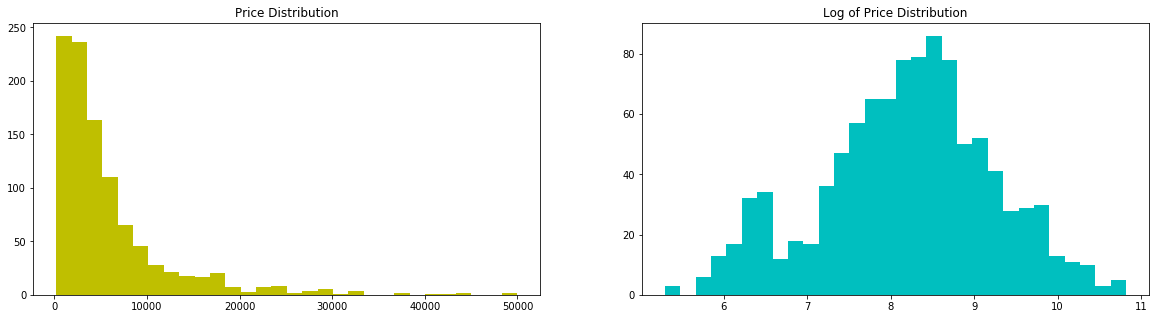

In [68]:
#Plot Price histogram (to check the distribution)
fig = plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.hist(clean_car_ad_dataset['Price'], bins=30, color = 'y')
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
plt.hist(np.log(clean_car_ad_dataset['Price']), bins=30, color = 'c')
plt.title('Log of Price Distribution')
plt.show()

**Explore the features**

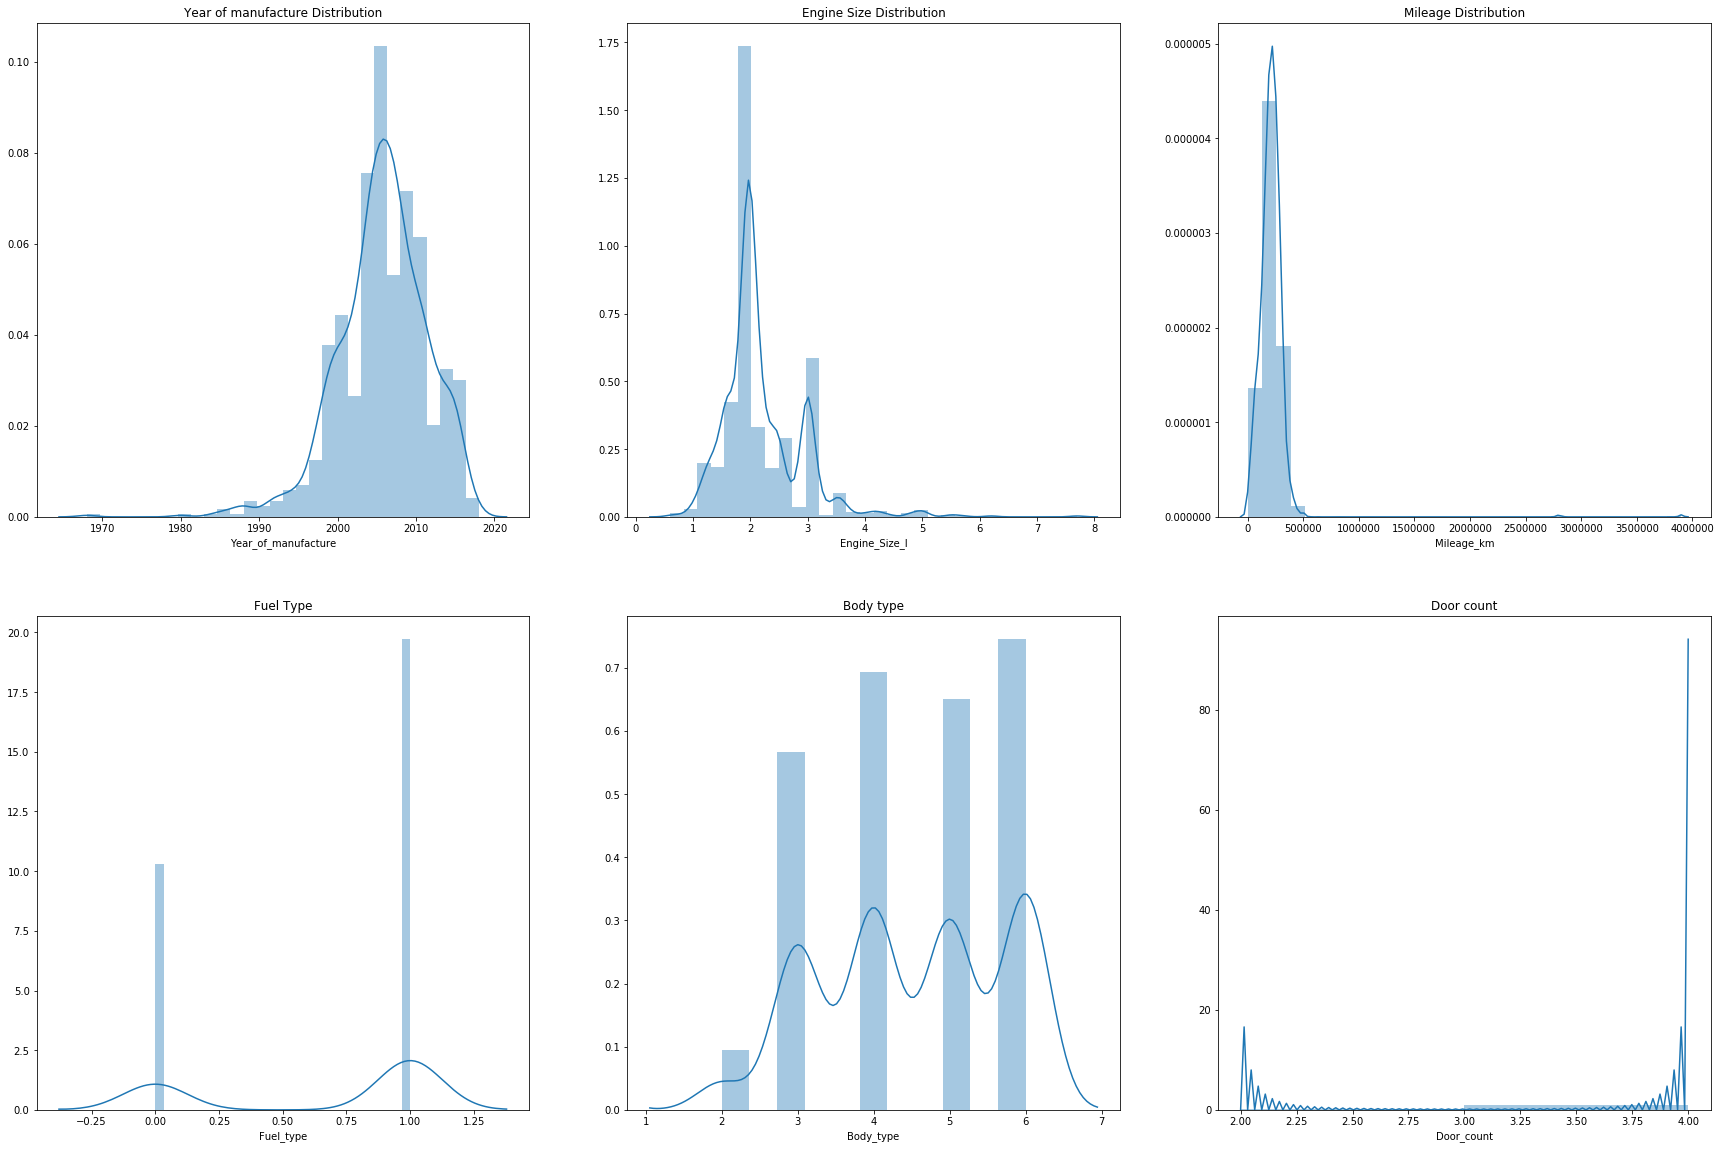

In [69]:
#Create a 2 x 3 plot matrix
fig = plt.figure(figsize = (30, 20))

#Distribution of years
plt.subplot(2, 3, 1)
sns.distplot(clean_car_ad_dataset["Year_of_manufacture"], bins = 30); 
plt.title('Year of manufacture Distribution')

#Distribution of Engine Size 
plt.subplot(2, 3, 2)
sns.distplot(clean_car_ad_dataset["Engine_Size_l"], bins = 30); 
plt.title('Engine Size Distribution')

#Distribution of Mileage 
plt.subplot(2, 3, 3)
sns.distplot(clean_car_ad_dataset["Mileage_km"], bins = 30); 
plt.title('Mileage Distribution')

#Distribution of Fuel Type
plt.subplot(2, 3, 4)
sns.distplot(clean_car_ad_dataset["Fuel_type"], bins = 30); 
plt.title('Fuel Type')

#Distribution of Body Type
plt.subplot(2, 3, 5)
sns.distplot(clean_car_ad_dataset["Body_type"]); 
plt.title('Body type')

#Distribution of Door count
plt.subplot(2, 3, 6)
sns.distplot(clean_car_ad_dataset["Door_count"], bins = 2); 
plt.title('Door count');


Text(0.5,1,'Mileage Distribution')

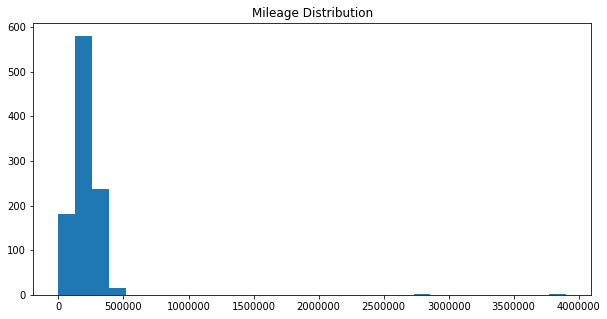

In [70]:
#Plot Mileage histogram (to check the distribution)
plt.figure(figsize = (10, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution')


In [71]:
#Checked Milage outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Mileage_km'] >= 1000000.0]
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Mileage_km'] <= 1000000.0]
#clean_car_ad_dataset.head()

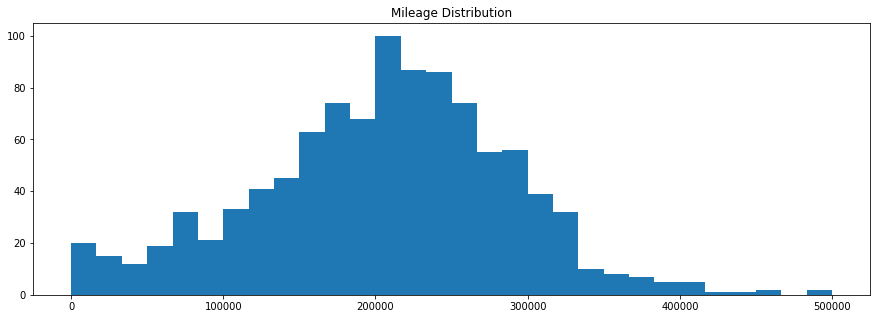

In [72]:
#Let's plot Mileage histogram again, after removing outliers (to check the distribution)
plt.figure(figsize = (15, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution');

### More analysis

In [73]:
#Check the correlation between different variables
clean_car_ad_dataset.corr()

,Is_German,Is_Japanese,Is_French,Body_type,Price,Year_of_manufacture,Engine_Size_l,Fuel_type,Gearbox,Mileage_km,Door_count,White_colour,Red_colour
Is_German,1.000000,-0.406609,-0.305324,-0.067604,0.206182,-0.069776,0.297411,0.028950,0.259029,0.123006,0.036127,0.002687,-0.072956
Is_Japanese,-0.406609,1.000000,-0.134621,0.030471,-0.058388,0.030155,-0.078285,-0.046872,-0.152372,-0.043333,-0.008534,-0.022655,-0.015261
Is_French,-0.305324,-0.134621,1.000000,0.043159,-0.122335,0.000431,-0.190099,0.021228,-0.111149,-0.041330,-0.018726,0.026884,0.093526
Body_type,-0.067604,0.030471,0.043159,1.000000,0.129678,0.126547,0.177711,0.241316,0.110107,0.103794,0.412397,0.052673,-0.111881
Price,0.206182,-0.058388,-0.122335,0.129678,1.000000,0.608840,0.347059,-0.050137,0.465711,-0.450056,0.063402,0.145361,-0.048948
Year_of_manufacture,-0.069776,0.030155,0.000431,0.126547,0.608840,1.000000,-0.014205,0.131884,0.292090,-0.448676,0.114178,0.128257,-0.094245
Engine_Size_l,0.297411,-0.078285,-0.190099,0.177711,0.347059,-0.014205,1.000000,-0.064953,0.517929,0.050364,0.118715,0.014911,-0.060309
Fuel_type,0.028950,-0.046872,0.021228,0.241316,-0.050137,0.131884,-0.064953,1.000000,-0.127039,0.307899,0.149309,-0.044867,-0.098826
Gearbox,0.259029,-0.152372,-0.111149,0.110107,0.465711,0.292090,0.517929,-0.127039,1.000000,-0.161584,0.080083,0.031137,-0.060855
Mileage_km,0.123006,-0.043333,-0.041330,0.103794,-0.450056,-0.448676,0.050364,0.307899,-0.161584,1.000000,0.097116,-0.081481,-0.086932


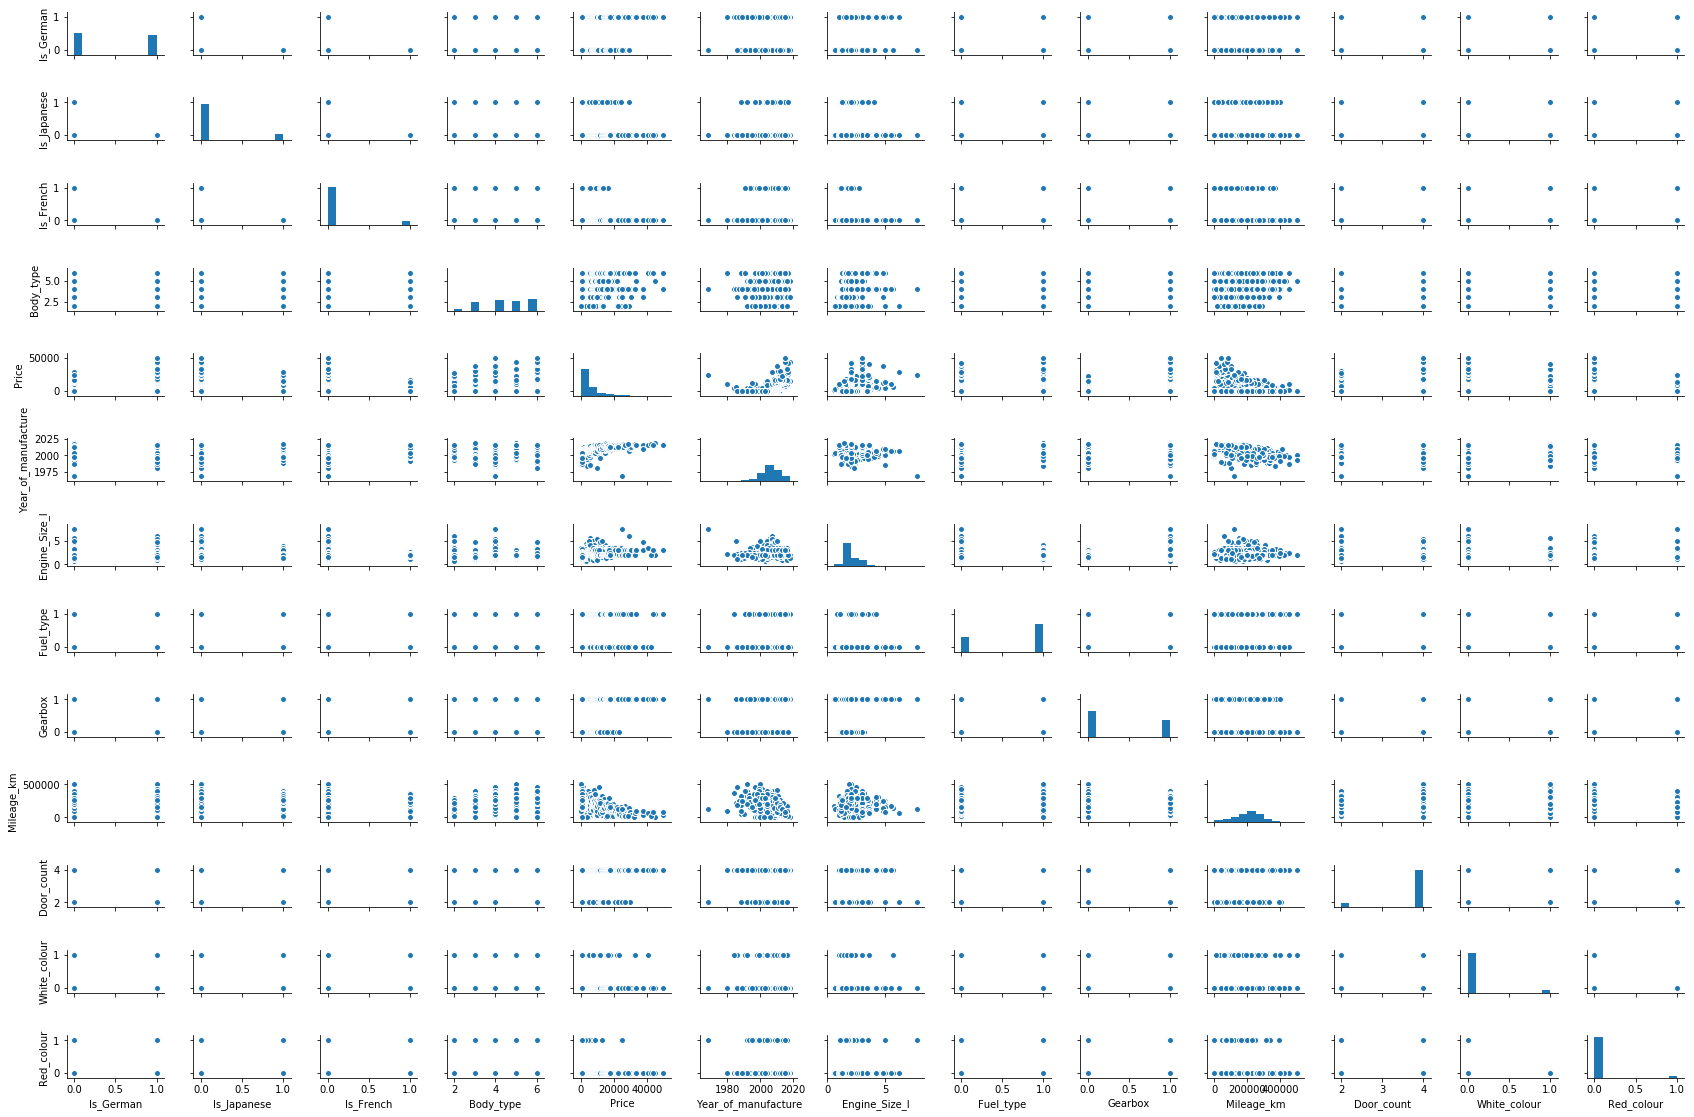

In [74]:
#Visualize the correlations
sns.pairplot(clean_car_ad_dataset, size = 1.2, aspect=1.5);

### Let's try modelling

**Training and testing**

In [77]:
#Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**Sklearn way**

In [76]:
#Create the feature matrix and target vector
X, y = clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox', 'Is_German']], clean_car_ad_dataset['Price']
car_ad_model = LinearRegression()

**Statsmodels way**

In [103]:
# #Create the target vector and feature matrix
m, K = patsy.dmatrices('Price ~ Year_of_manufacture + Engine_Size_l + Mileage_km + Fuel_type + Gearbox + Is_German + Is_French + Is_Japanese', clean_car_ad_dataset)

#Linear Regression
car_ad_model_sms = sm.OLS(m, K)
car_ad_model_sms_fit = car_ad_model_sms.fit()
car_ad_model_sms_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     173.9
Date:                Sun, 15 Jul 2018   Prob (F-statistic):          1.12e-183
Time:                        18:57:56   Log-Likelihood:                -9902.7
No. Observations:                1013   AIC:                         1.982e+04
Df Residuals:                    1004   BIC:                         1.987e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.122e+06   5.97e+04    -18.798      0.000   -1.24e+06      -1e+06
Year_of_manufacture   560.7555     29.673     18.898      0.000     502.528     618.984
Engine_Size_l        2426.9425    234.788     10.337      0.000    1966.211    2887.674
Mileage_km             -0.0194      0.002     -9.719      0.000      -0.023      -0.015
Fuel_type            -159.8312    319.731     -0.500      0.617    -787.249     467.587
Gearbox              1434.3023    355.197      4.038      0.000     737.288    2131.316
Is_German            2212.5839    334.229      6.620      0.000    1556.717    2868.451
Is_French            -403.6213    514.827     -0.784      0.433   -1413.882     606.640
Is_Japanese           334.4567    431.487      0.775      0.438    -512.264    1181.177
==============================================================================
Omnibus:                      633.883   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8490.451
Skew:                           2.662   Prob(JB):                         0.00
Kurtosis:                      16.146   Cond. No.                     9.81e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Results with just Year_of_manufacture: adj.R2 = 0.581, F-stat = 1407, Log-like = -1026
Results with just Year_of_manufacture and Engine Size: adj.R2 = 0.739, F-stat = 1423, Log-like = -787.28
Results with just Year_of_manufacture, Engine Size and Mileage: adj.R2 = 0.744, F-stat = 979.9, Log-like = -777.16
Results with just Year_of_manufac, Engine Size, Mileage and Fuel type: adj.R2 = 0.745, F-stat = 740, Log-like = -774
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type and Gearbox: adj.R2 = 0.754, F-stat = 622, Log-like = -755
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox and Is_German: adj.R2 = 0.771, F-stat = 568, Log-like = -719
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox and Is_German: adj.R2 = 0.778, F-stat = 508, Log-like = -702
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox and Is_German: adj.R2 = 0.780, F-stat = 450, Log-like = -697

In [123]:
#Do the cross-validation
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(car_ad_model, X_train, y_train, cv = 5, scoring='r2')
print('The r-squared scores of cross validation:', str(scores), '\n')
print('The mean of r-squared scores is', str(round(scores.mean(), 3))+ '.\n')

scores = cross_val_score(car_ad_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
print('The mean squared error scores of cross validation:', str(-scores), '\n')
print('The mean of the mean squared error scores is:', str(round(-scores.mean(), 0)))

The r-squared scores of cross validation: [0.57547473 0.4928811  0.61139114 0.58025983 0.61725317] 

The mean of r-squared scores is 0.575.

The mean squared error scores of cross validation: [23976506.62072767 20248151.48100242 13384973.0973021  16757153.20197729
 19940973.41600579] 

The mean of the mean squared error scores is: 18861552.0


In [79]:
car_ad_model_fit = car_ad_model.fit(X_train, y_train)
print('The score on the training data', str(car_ad_model.score(X_train, y_train)))
print('The score on the testing data', str(car_ad_model_fit.score(X_test, y_test)))

The score on the training data 0.5921859648597003
The score on the testing data 0.5178349726419151


### Examing Residuals

KeyError: 917

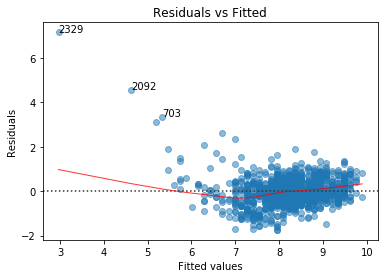

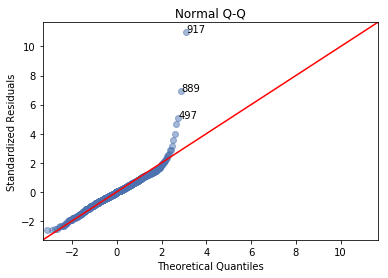

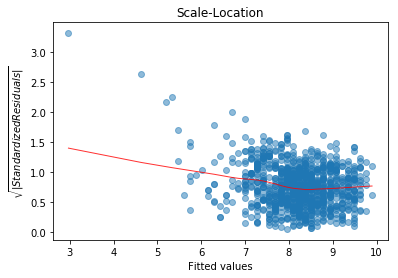

In [80]:
# Use diagnostic_plots python file to plot Year of manufacture results
diagnostic_plots(clean_car_ad_dataset['Year_of_manufacture'], np.log(clean_car_ad_dataset['Price']))

In [ ]:
#Explore residual extremes


KeyError: 85

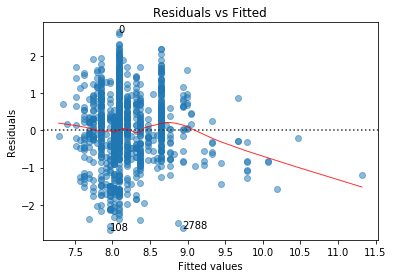

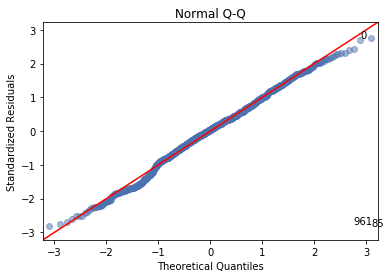

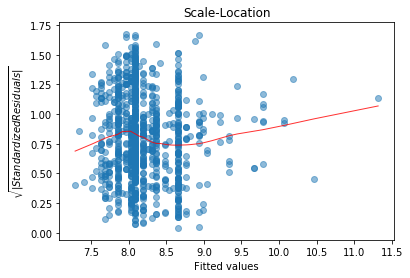

In [109]:
# Use diagnostic_plots python file to plot Engine Size (l) results
diagnostic_plots(clean_car_ad_dataset['Engine_Size_l'], np.log(clean_car_ad_dataset['Price']))

KeyError: 935

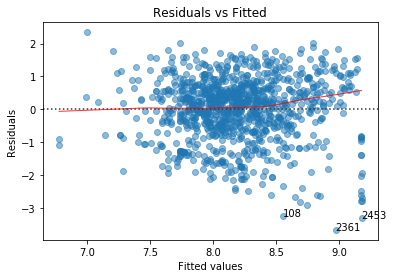

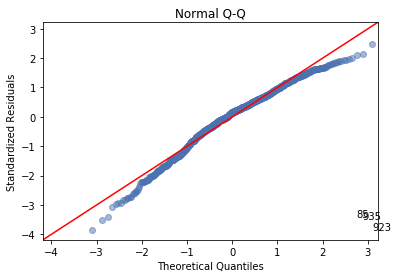

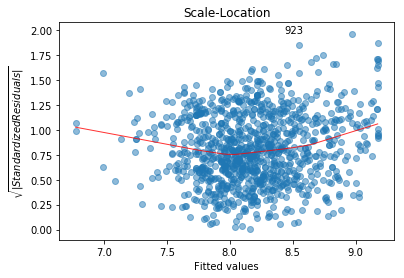

In [110]:
# Use diagnostic_plots python file to plot Mileage (km) results
diagnostic_plots(clean_car_ad_dataset['Mileage_km'], np.log(clean_car_ad_dataset['Price']))